# Agent Learning Project

## Imports 

We start by importing the required libaries. Uncomment & run the next cell in case some of the libraries aren't installed in your environment. 

In [1]:
# !pip install numpy matplotlib

In [2]:
import numpy as np # Useful for computations and probabilistic distributions
import matplotlib.pyplot as plt # Plotting Graph for Simulation results
from collections import defaultdict # Specific kind of dictionary that avoids KeyErrors

## Defining the Agent class

We define a type of agent with the following attributes: 
- Agent name : Name of the agent
- Service probability : If at the counter, shows the probability that this agent will be serviced.
- Reward : Reward the counter gets for servicing this agent
- Time in queue : Time for which the agent has been in the queue. 

In [3]:
class Agent:
    def __init__(self, name):
        self.name = name
        self.service_prob, self.reward, self.penalty = agents[name][:3]
        self.time_in_queue = 0

    def __eq__(self, other):
        if self is None or other is None: 
            return False
        return self.name == other.name

    def __str__(self):
        return f"Agent {self.name} ({self.time_in_queue})"

## Defining the Queue mechanism 

In [4]:
class QueueSimulation:
    def __init__(self, agents, arrival_prob, init, alpha, discount, truncation):
        # Define the agents, their distribution, and the strategy
        self.agents = agents
        self.agent_distribution = np.array([agent[3] for agent in agents.values()])
        self.agent_distribution = self.agent_distribution / np.sum(self.agent_distribution)
        
        # Define the hyper-parameters of the simulation
        self.arrival_prob, self.init, self.alpha, self.discount = arrival_prob, init, alpha, discount
        self.fixed_discount, self.discount = discount, 1 # Optimization trick to avoid recomputing power at each step
        
        # Define the Queue
        if type(init) == int:
            self.queue = [self.create_agent() for _ in range(init)]  
        else:
            self.queue = init
        self.current_agent = None if len(self.queue) == 0 else self.queue[0]
        self.truncation = truncation
        
        # Variables that are used to analyze our code
        self.time, self.busy, self.total_reward, self.discounted_reward = 0, 0, 0, 0

        # Tracking previous state and action for Q-learning updates
        self.prev_state = None
        self.prev_action = None
        
        # Tracking the history for graphs
        self.serviced_agents = defaultdict(int)
        self.reward_history, self.queue_length_history = [], []

    def create_agent(self):
        name = np.random.choice(list(self.agents.keys()), p=self.agent_distribution)
        return Agent(name)

    def step(self):
        """
        This function is the core of the simulation. It defines what happens at every step. The order in which 
        the computations are made is important so we have to be careful. In our case, we proceed as follows:
        
        1. Determine whether an agent is joining the queue
        2. Detemine if the agent in service is going to complete service or not and potentially add reward 
        3. Add penalty to the reward
        4. Apply the given strategy to determine what happens next
        5. Add the information related to the step to the simulation history
        
        Please feel free to ask for any changes in the implementation
        """
        self.time += 1 # Update time
        self.discount *= self.fixed_discount # Update Discount
        reward_this_step = 0
        
        # Add new agent to the queue based on arrival probability
        if np.random.rand() < self.arrival_prob:
            new_agent = self.create_agent()
            agent_count = sum(1 for agent in self.queue if agent.name == new_agent.name)
            if agent_count < truncation:
                # If there is too much of this agent in the queue, we reject the new entry
                self.queue.append(new_agent)

        # Check if the current agent is done being served
        if self.current_agent:
            if np.random.rand() < self.current_agent.service_prob:
                agent_serviced_this_step = self.current_agent
                reward_this_step += self.current_agent.reward
                self.total_reward += self.current_agent.reward
                self.discounted_reward += self.current_agent.reward*self.discount
                self.serviced_agents[self.current_agent.name] += 1
                self.current_agent = None
        
        length = len(self.queue)
        
        # Apply penalty on reward
        for agent in self.queue: 
            agent.time_in_queue += 1
            reward_this_step -= agent.penalty
            self.total_reward -= agent.penalty
            self.discounted_reward -= agent.penalty*self.discount
        reward_this_step -= regularization(self.alpha,length)
        self.total_reward -= regularization(self.alpha,length)
        self.discounted_reward -= regularization(self.alpha,length)*self.discount

        # Apply the strategy to select the next agent
        if self.queue:
            self.q_learning_strategy(reward_this_step)
        
        # Add the step's information to the simulation history
        self.reward_history.append(self.total_reward)
        self.queue_length_history.append(length)
        self.busy += bool(self.current_agent)

    def q_learning_strategy(self, reward):
        state = q_agent.get_state(self.queue, self.current_agent, self.agents)
        action_name = q_agent.choose_action(state, self.queue, self.current_agent)
        if action_name is None or (self.current_agent and self.current_agent.name == action_name):
            # Nothing can be done action
            return
        action_index = next(i for i, agent in enumerate(self.queue) if agent.name == action_name)

        # Save the previous state and action for Q-learning update
        self.prev_state = state
        self.prev_action = action_name
        
        if self.current_agent:
            self.queue[action_index] = self.current_agent
            self.current_agent = Agent(action_name)
        else:
            self.current_agent = self.queue.pop(action_index)

        # Observe the next state
        next_state = q_agent.get_state(self.queue, self.current_agent, self.agents)
        
        # Update the Q-table
        if self.prev_state is not None and self.prev_action is not None:
            q_agent.update_q_table(self.prev_state, self.prev_action, reward, next_state)

    
    def run_simulation(self, steps=1000):
        for _ in range(steps):
            self.step()

    def get_results(self):
        # Plot total reward over time
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.reward_history)
        plt.title('Total Reward over Time')
        plt.xlabel('Time')
        plt.ylabel('Total Reward')

        # Plot queue length over time
        plt.subplot(1, 3, 2)
        plt.plot(self.queue_length_history)
        plt.title('Queue Length over Time')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')

        # Plot distribution of serviced agents by type
        plt.subplot(1, 3, 3)
        agent_types, counts = zip(*sorted(self.serviced_agents.items()))
        plt.bar(agent_types, counts)
        plt.title('Distribution of Serviced Agents by Type')
        plt.xlabel('Agent Type')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()
        
        self.min_queue_length = np.min(self.queue_length_history)
        self.max_queue_length = np.max(self.queue_length_history)
        self.mean_queue_length = np.mean(self.queue_length_history)
        self.normalized_distribution = {agent_type: round(count / sum(self.serviced_agents.values()), 3) for agent_type, count in sorted(self.serviced_agents.items(), key=lambda item: item[1], reverse=True)}

        
        print(f"\nTotal reward: {self.total_reward}")
        print(f"Discounted reward: {self.discounted_reward}")
        print(f"Average reward per step: {self.total_reward/self.time}")
        print(f"Min & Max Queue Length: {self.min_queue_length} & {self.max_queue_length}")
        print(f"Mean Queue Length: {self.mean_queue_length}")
        print(f"Normalized Distribution of Serviced Agents: {self.normalized_distribution}")
        print(f"Time spent busy: {self.busy/self.time}")
        print(f"--------------------------------------------------------")


In [5]:
# Compute average service probability
def service():
    service_prob = np.array([agent[0] for agent in agents.values()])
    weights = np.array([agent[3] for agent in agents.values()])
    distribution = weights / np.sum(weights)
    x = np.dot(service_prob, distribution.T)
    if x == 0:
        return 0, float('inf')
    return x,1/x

# Compute expected reward per agent
def average():
    probabilities = np.array([agent[0] for agent in agents.values()])
    rewards = np.array([agent[1] for agent in agents.values()])
    penalties = np.array([agent[2] for agent in agents.values()])
    average_values = {agent: rewards[i]*probabilities[i] - penalties[i]/probabilities[i] for i, agent in enumerate(agents.keys())}
    return average_values

# Create the initial list
def create(l, shuffle=False):
    queue = []
    for name, quantity in l:
        queue += [Agent(name)] * quantity
    if shuffle:
        np.random.shuffle(queue)
    return queue

## Defining the Q-Learning Agent

In [6]:
class QLearningAgent:
    def __init__(self, agents, truncation, discount, learning_rate, epsilon, epsilon_function):
        self.agents, self.num_agents, self.truncation = agents, len(agents), truncation
        self.discount, self.learning_rate, self.epsilon = discount, learning_rate, epsilon
        self.epsilon_function = epsilon_function
        self.q_table = defaultdict(lambda: {agent:0 for agent in agents.keys()})

    def get_state(self, queue, current_agent, agents):
        state = {agent: 0 for agent in list(agents.keys())}
        if current_agent:
            state[current_agent.name] += 1
        for i, agent in enumerate(queue):
            if min(state.values()) >= self.truncation: break
            if state[agent.name] > self.truncation: continue
            state[agent.name] += 1
        return tuple(state.items())

    def choose_action(self, state, queue, current_agent):
        valid_actions = list({agent.name for agent in queue})
        if current_agent: valid_actions.append(current_agent.name)
        if not valid_actions: return None
        if np.random.rand() < self.epsilon:
            self.epsilon = self.epsilon_function(self.epsilon)
            return np.random.choice(valid_actions)
        self.epsilon = self.epsilon_function(self.epsilon)
        state_values = {action: self.q_table[state][action] for action in valid_actions}
        action = max(state_values, key=state_values.get)
        return action

    def update_q_table(self, state, action, reward, next_state):
        next_state_values = self.q_table[next_state]
        best_next_action = max(next_state_values, key=next_state_values.get)
        td_target = reward + self.discount * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

## Choosing base parameters

In [7]:
# Number of steps for the simulation
steps = 10_000_000

# Defining Agents
agents = {
    ### Agent name : [service_probability, reward, penalty, distrib_weight]
    # service_probability: float in [0,1]
    # reward, penalty, distrib_weight: float (unconstrained)
    "Alex" : [0.5, 50, 0, 3], 
    "Ben" : [0.25, 5, 0, 3],
    "Cameron" : [0.3, 30, 0, 0],
    "Dennis" : [0.4, 20, 0, 0],
    "Eric": [0.75, 200, 0, 3],
    "Fabien": [0.3, 50, 0, 0],
}

# Probabilty that a new agent joins the queue
arrival_prob = 1

# Number of agents in the queue at t = 0
# We either choose a random weighted queue or a specific queue
start = 0
queue = create([("Fabien", 1)], False) # [(name, quantity),(name, quantity),...], shuffle=True/False 
init = start # Choose a mode here

# Choose a discount factor for discounted reward computation
discount = 0.9

# Regularization parameter and function
alpha = 0.00
def regularization(alpha,length):
    return alpha*length

# Initialize Q-Learning Agent
truncation = 100
learning_rate = 0.1
epsilon = 0.25

# Epsilon decaying function
def epsilon_function(epsilon):
    return epsilon 
    # return max(epsilon - 2/steps,0)

q_agent = QLearningAgent(agents, truncation, discount, learning_rate, epsilon, epsilon_function)

## Running the Q-Learning model

Execute the main code automatically by choosing one of the strategies defined above in the 'Define Strategies' section and letting the computer play by itself. This function outputs three graphs. 
- Graph 1: Total reward from time $t_0$ to time $t_{1000}$.
- Graph 2: Length of the Queue from time $t_0$ to time $t_{1000}$.
- Graph 3: Distribution of serviced Agents by type from $t_0$ to time $t_{1000}$.



Expected service probability & time across agents: (0.5, 2.0)
Expected reward + weighted penalty for each agent: {'Alex': 25.0, 'Ben': 1.25, 'Cameron': 9.0, 'Dennis': 8.0, 'Eric': 150.0, 'Fabien': 15.0}


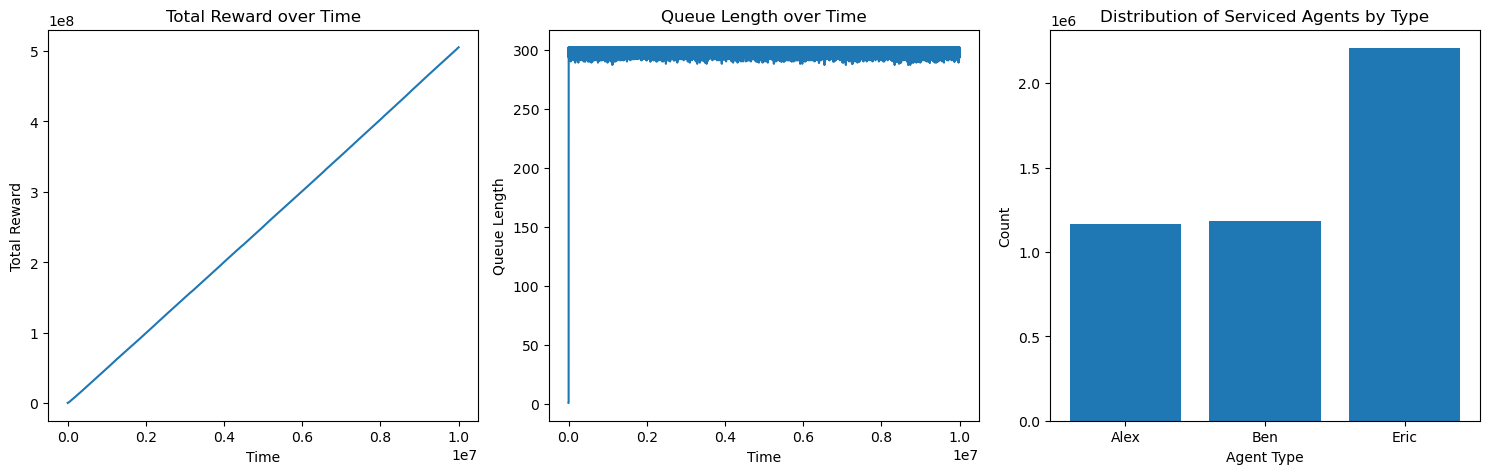


Total reward: 505453235.0
Discounted reward: 360.64061588691237
Average reward per step: 50.5453235
Min & Max Queue Length: 1 & 302
Mean Queue Length: 298.4859321
Normalized Distribution of Serviced Agents: {'Eric': 0.485, 'Ben': 0.26, 'Alex': 0.255}
Time spent busy: 1.0
--------------------------------------------------------


In [8]:
simulation = QueueSimulation(
    agents,
    arrival_prob,
    init,
    alpha,
    discount,
    truncation
)

print(f"Expected service probability & time across agents: {service()}")
print(f"Expected reward + weighted penalty for each agent: {average()}")
simulation.run_simulation(steps)
simulation.get_results()

In [9]:
q_agent.q_table

defaultdict(<function __main__.QLearningAgent.__init__.<locals>.<lambda>()>,
            {(('Alex', 0),
              ('Ben', 0),
              ('Cameron', 0),
              ('Dennis', 0),
              ('Eric', 1),
              ('Fabien', 0)): {'Alex': 0,
              'Ben': 0,
              'Cameron': 0,
              'Dennis': 0,
              'Eric': 0.0,
              'Fabien': 0},
             (('Alex', 1),
              ('Ben', 0),
              ('Cameron', 0),
              ('Dennis', 0),
              ('Eric', 0),
              ('Fabien', 0)): {'Alex': 20.0,
              'Ben': 0,
              'Cameron': 0,
              'Dennis': 0,
              'Eric': 0,
              'Fabien': 0},
             (('Alex', 1),
              ('Ben', 0),
              ('Cameron', 0),
              ('Dennis', 0),
              ('Eric', 1),
              ('Fabien', 0)): {'Alex': 0,
              'Ben': 0,
              'Cameron': 0,
              'Dennis': 0,
              'Eric': 0.0,
     

# Comments

In case something needs to be changed, please feel free to write something in the cell below and email me about it. 